In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
import json
import os
from pandas.tseries.offsets import MonthEnd
from plotting import * 
import modify_dataset  
from itertools import combinations
from scipy.stats import entropy
import matplotlib.patches as mpatches

In [2]:
def Pielou_evenness(data): 
    if data.size == 1: 
        return 0
    H = entropy(data, base = 10)
    H_max = np.log10(len(data))
    return H / H_max

In [3]:
with open(path.expanduser("~") + "/sys_specific.json") as file: 
    params = json.load(file)
_HOME_ = params["home"] + "/PHD"

In [31]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)
taxonomic_tree = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]
higher_than_class = ['Other phytoplankton', "Haptophyta", "Noctilucea", "Non flagellates"]
sites_species = phyto_abund_simplified.set_index(["id", "Date"]).loc[:, ["Taxon", "Num_cell_l"]].query("Taxon not in @higher_than_class").pivot_table(index = ["id", "Date"], columns="Taxon", values = "Num_cell_l", fill_value=0)

In [5]:
cluster_index = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Results/cluster_index.csv", index_col= [0,1]).reset_index()
cluster_index["Date"] = pd.to_datetime(cluster_index["Date"])

## add also ward 10 and 11

In [32]:
sites_taxa = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/site_taxa_matrix.csv", index_col = [0,1])
#hellinger transformation
abund_hellinger = sites_taxa.apply(lambda x: np.sqrt(x / sum(x)), axis = 1)
X = abund_hellinger.values

In [33]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
def build_linkage_matrix(model) -> np.ndarray : 
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

In [34]:
single_linkage_clustering = AgglomerativeClustering(n_clusters = None, metric = "euclidean", linkage = "ward", compute_distances = True, compute_full_tree=True, distance_threshold=0.0)
linkage_clusters = single_linkage_clustering.fit(X)
linkage_matrix = build_linkage_matrix(linkage_clusters)
for n in [9, 10, 11]:
    cluster_index[f"ward_{n}"] = fcluster(linkage_matrix, t = n, criterion = "maxclust")

In [35]:
phyto_abund_simplified = phyto_abund_simplified.merge(cluster_index, on = ["id", "Date"])

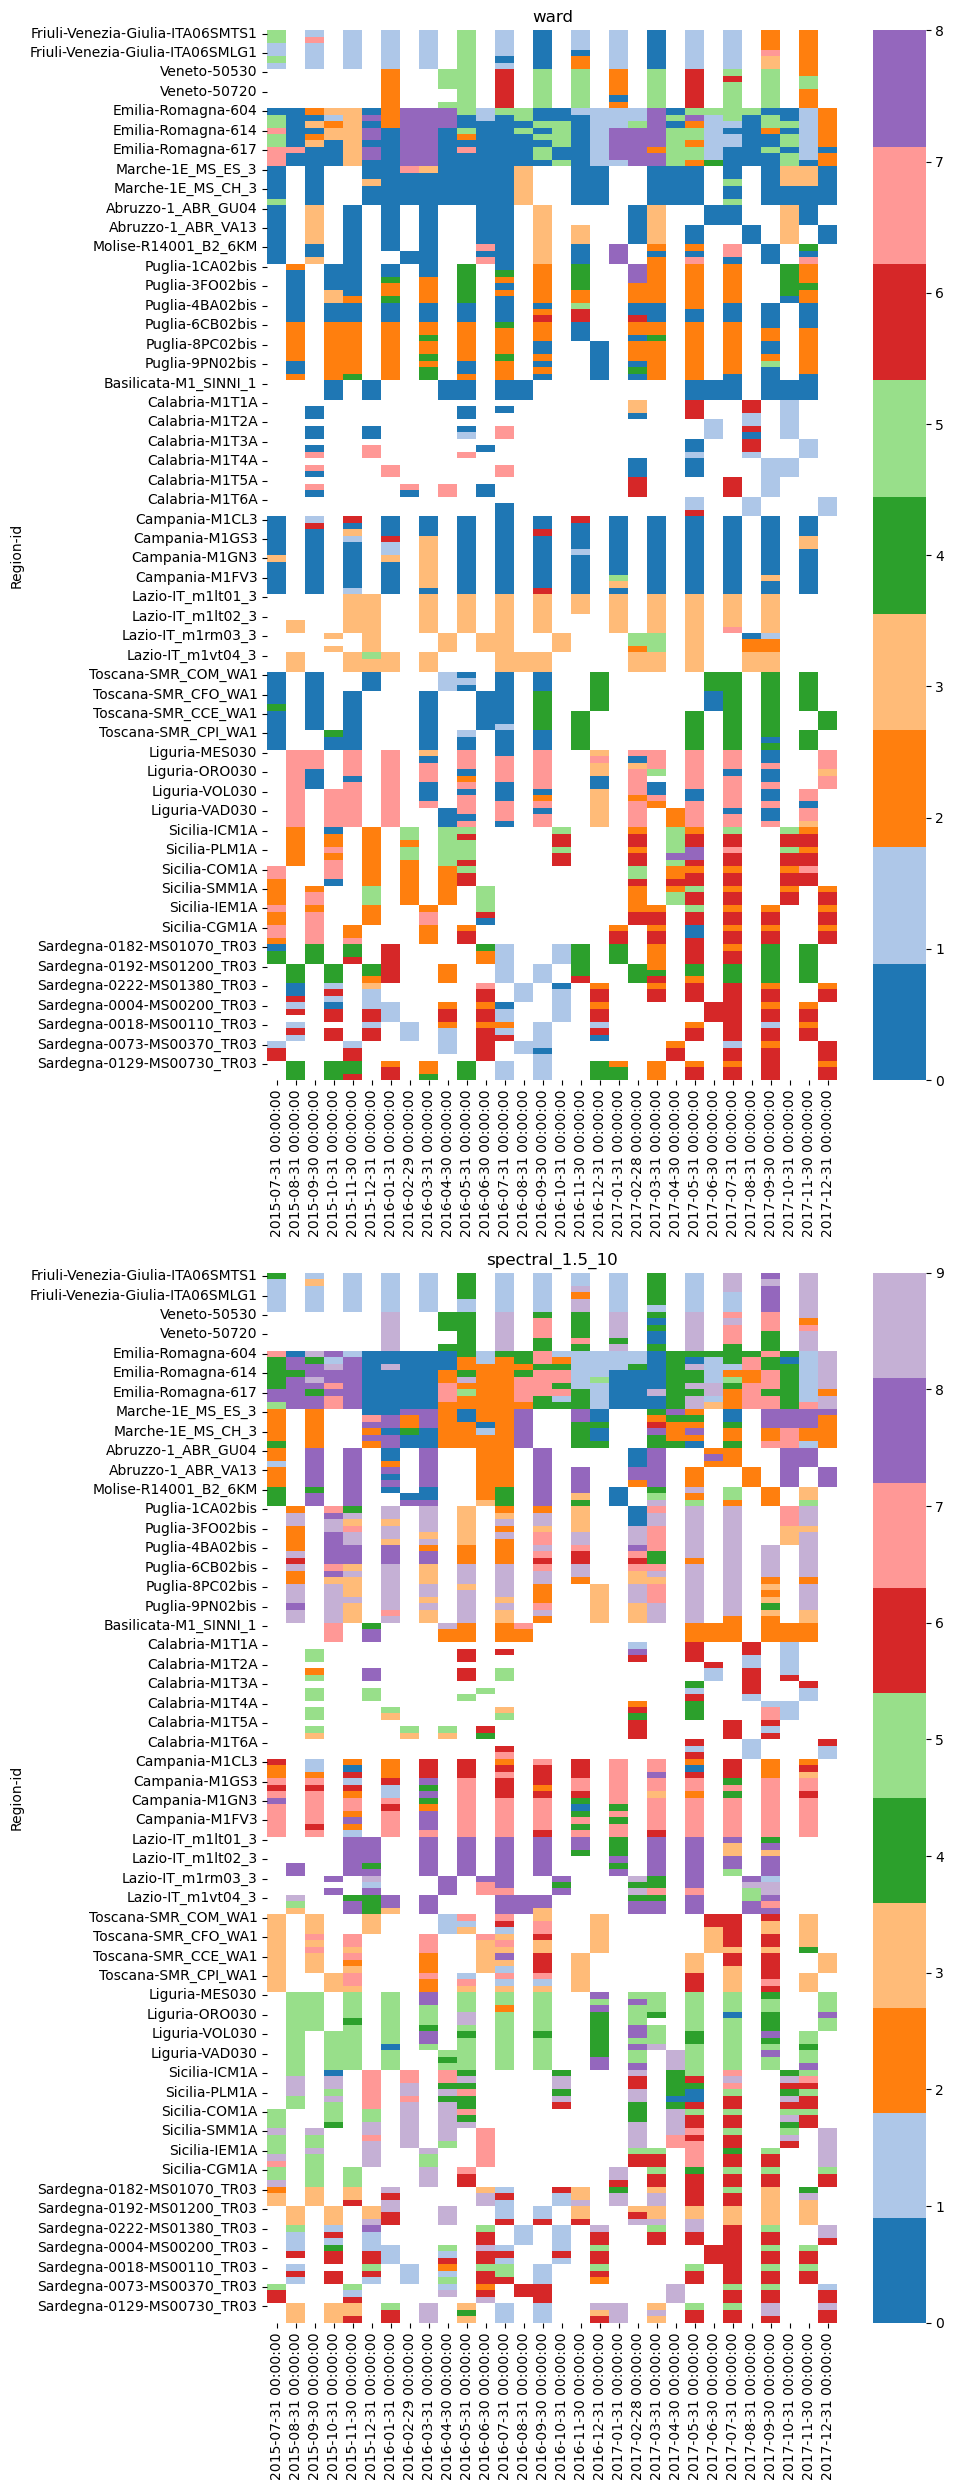

In [7]:
fig, axs = plt.subplots(2, 1, figsize = (10, 25))
axs = axs.flatten() 
for (ax, method) in zip(axs, ["ward", "spectral_1.5_10"]): 
    df = pd.DataFrame(data = {"label" : cluster_index[method].to_numpy()}, index = sites_species.index).pivot_table(index = "id", columns = "Date", values = "label")
    df.index = pd.Categorical(df.index, categories = ordered_id, ordered = True)
    df.index.name = "id"
    df = df.merge(phyto_abund_simplified.loc[:, ["Region", "id"]].drop_duplicates(), how = "left", on = "id").set_index(["Region", "id"]).sort_index()
    cmap = sns.color_palette("tab20", np.unique(df.values).size -1)
    sns.heatmap(df, ax = ax, cmap = cmap)
    ax.set_title(method)
plt.tight_layout()

# Ward

### characterization of clusters

In [36]:
characterazation_clusters = {}
for method in ["ward_9", "spectral_1.5_10", "ward_10", "ward_11"]: 
    n_samples_region_season = phyto_abund_simplified.groupby(["Region", "Season", "id"], observed=True)["Date"].nunique().reset_index().groupby(["Region", "Season"], observed=True)["Date"].sum()
    n_samples_cluster_region_season = phyto_abund_simplified.groupby([method, "Region", "Season", "id"], observed=True)["Date"].nunique().reset_index().groupby([method, "Region", "Season"], observed=True)["Date"].sum()
    clust_subdivision = n_samples_cluster_region_season.div(n_samples_region_season).reset_index().sort_values([method, "Region", "Season"]).pivot_table(index = method, columns = ["Region", "Season"], values = "Date").T
    characterazation_clusters[method] = clust_subdivision

In [71]:
import matplotlib.colors as mcolors

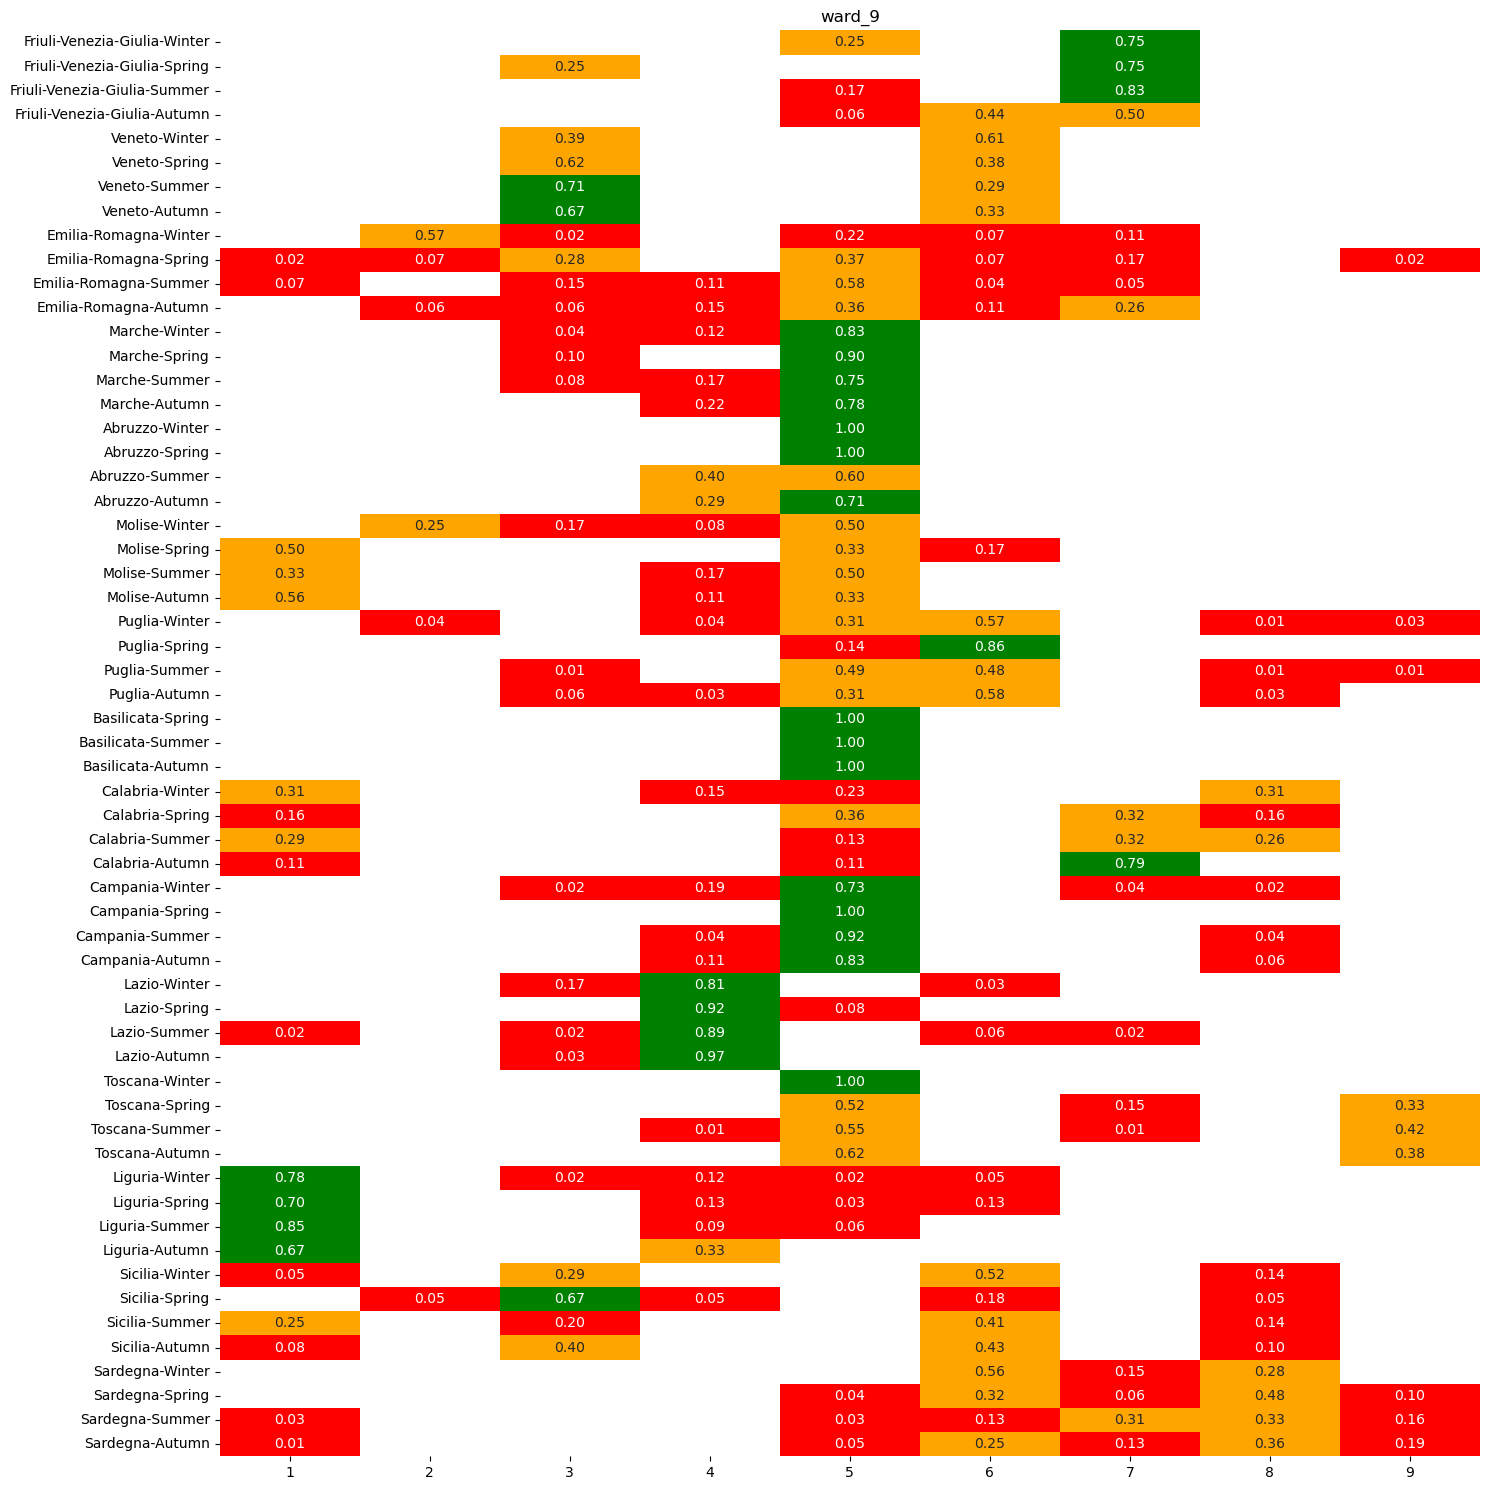

In [120]:
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
method = "ward_9"
my_colors = ["red", "orange", "green"]
bounds = [0, 0.25, 0.65, 1]
cmap = mcolors.ListedColormap(my_colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
sns.heatmap(characterazation_clusters[method], 
            ax = ax, 
            cmap = my_colors, 
            norm = norm,
            cbar = False, 
            annot=True, 
            fmt=".2f", 
            yticklabels=[f"{Region}-{Season}" for Region, Season in characterazation_clusters[method].index])
ax.set_title(method)
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()

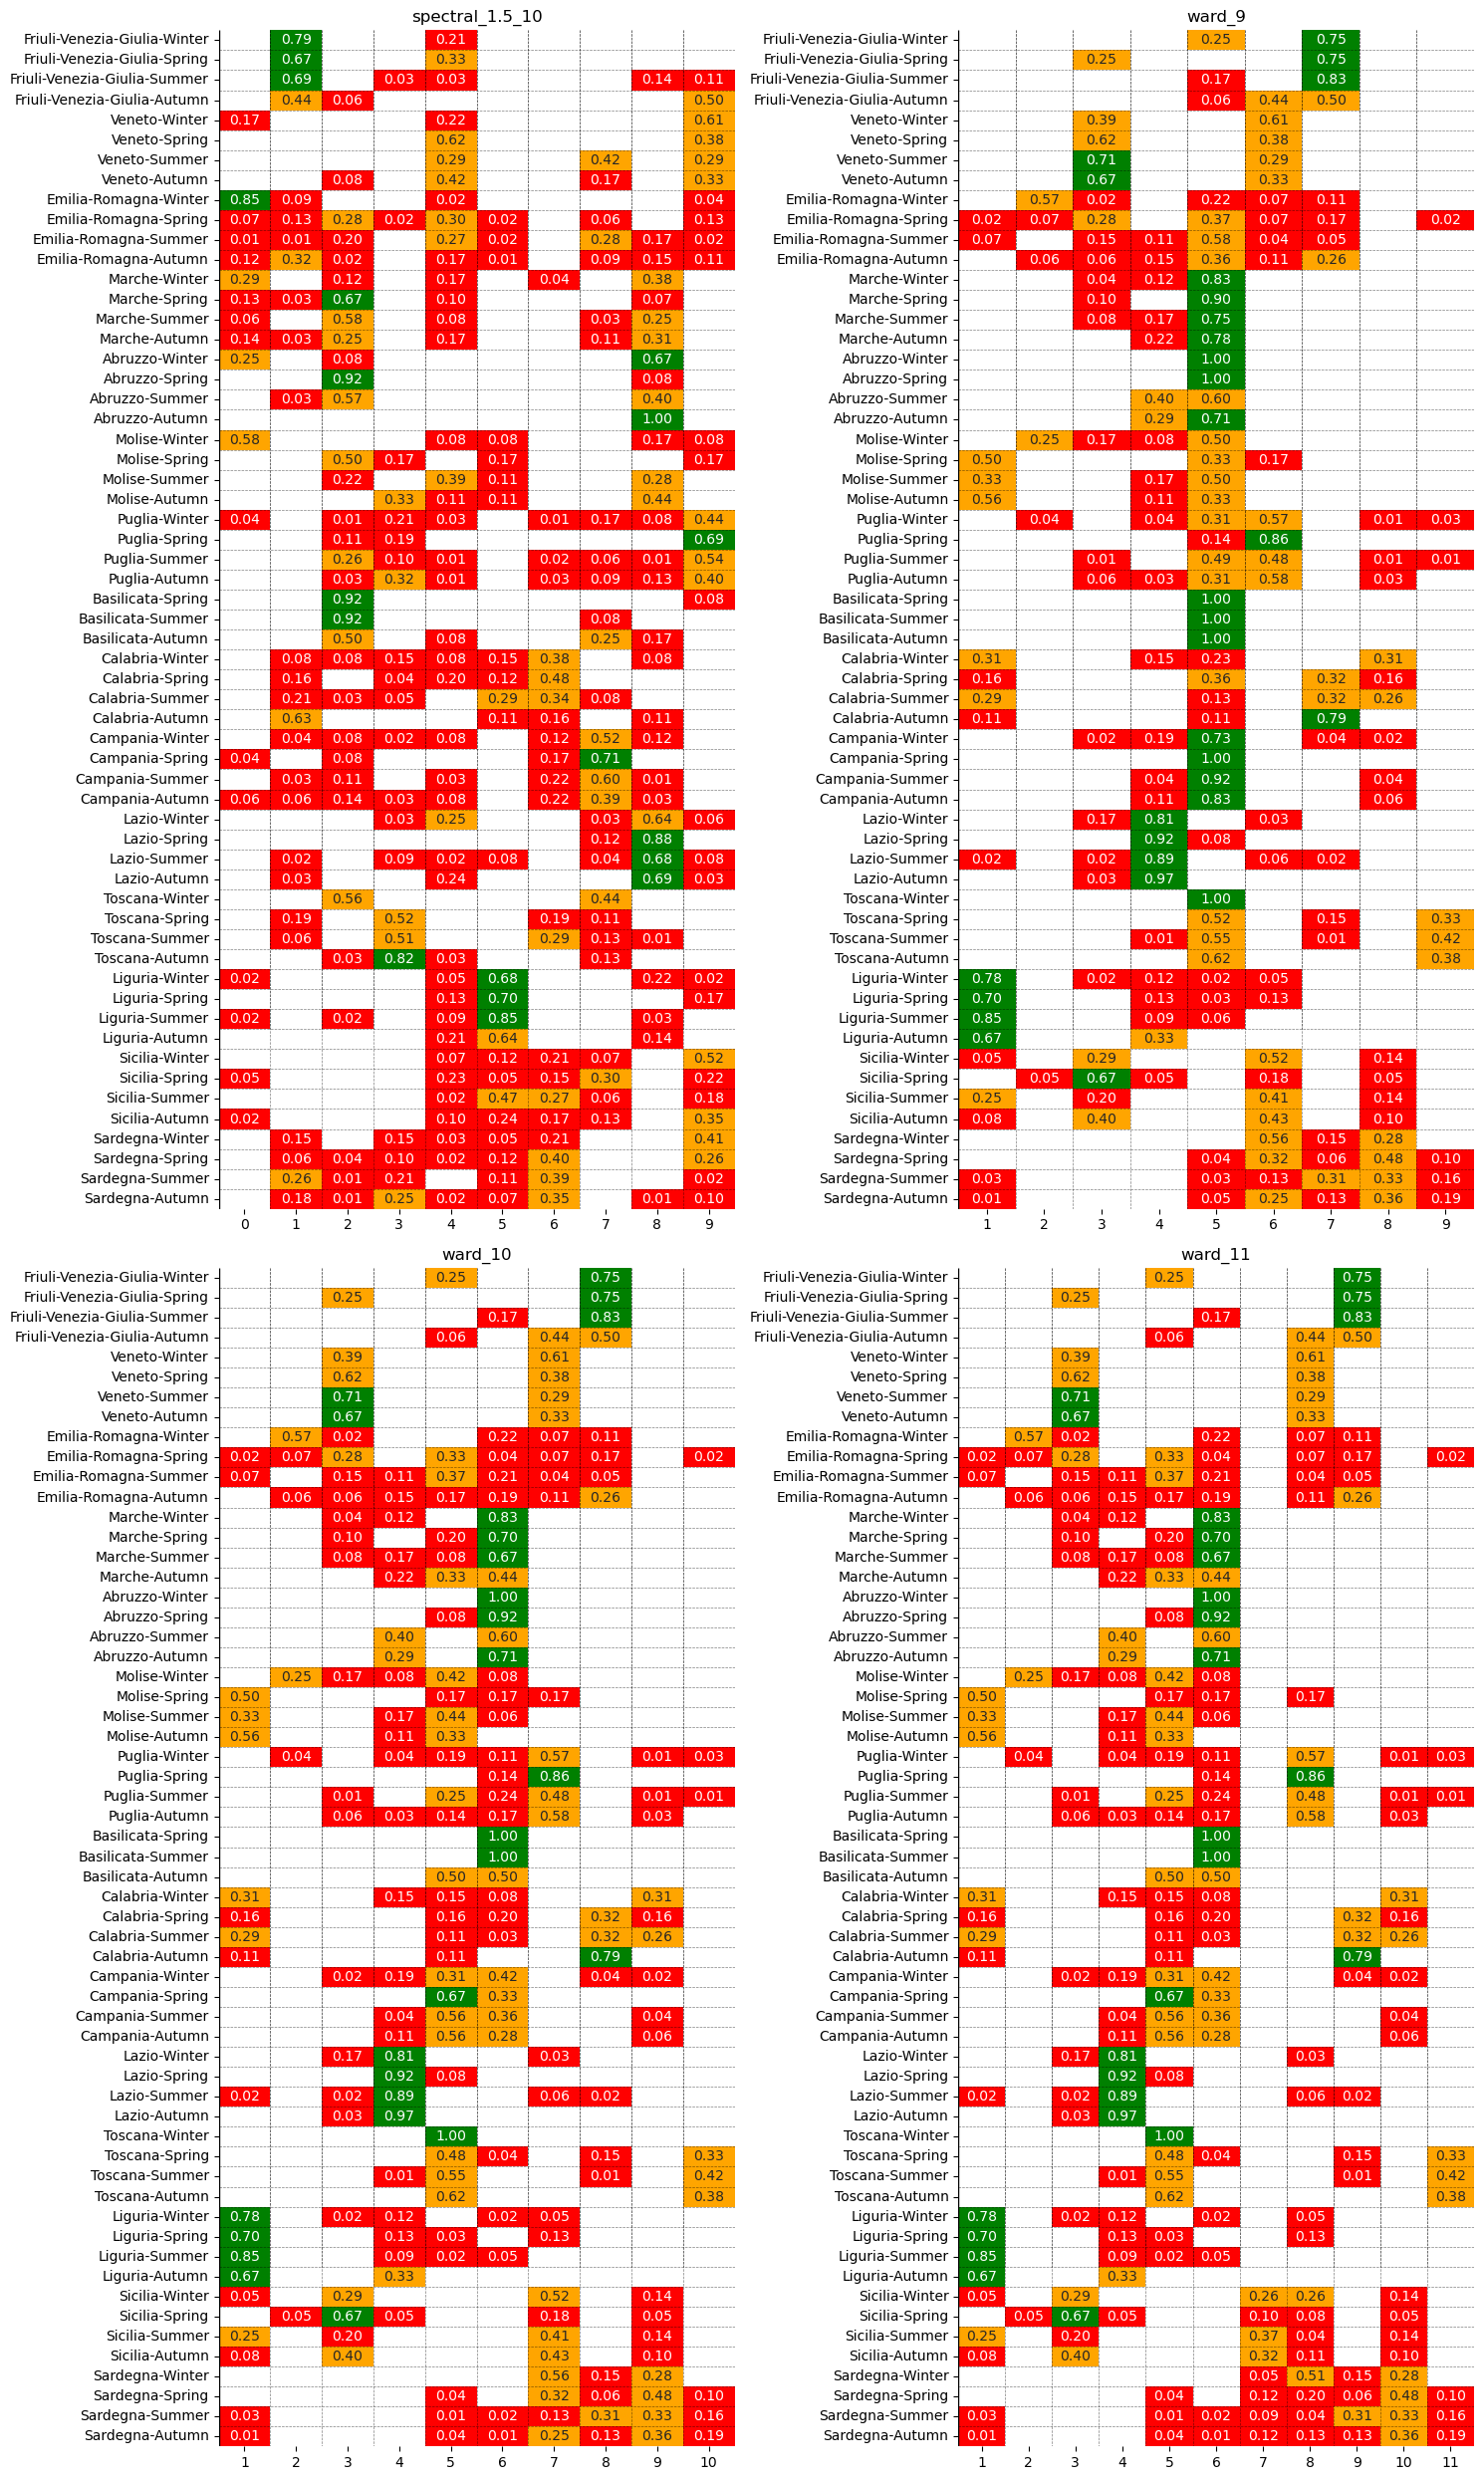

In [131]:
fig, axs = plt.subplots(2, 2, figsize = (15, 25))
axs = axs.flatten()
colors = ["red", "orange", "green"]
bounds = [0, 0.25, 0.65, 1]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
for (ax, method) in zip(axs, ["spectral_1.5_10", "ward_9", "ward_10", "ward_11"]): 
    sns.heatmap(characterazation_clusters[method], 
                ax = ax, 
                cmap = cmap,
                norm = norm, 
                cbar = False, 
                annot=True, 
                fmt=".2f", 
                yticklabels=[f"{Region}-{Season}" for Region, Season in characterazation_clusters[method].index])
    w = ax.get_xticks()
    v = ax.get_yticks()
    delta_xtick = w[1] - w[0] 
    ax.vlines([i + delta_xtick / 2 for i in w], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
    ax.vlines([i - delta_xtick / 2 for i in w[1:]], 0, 50, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
    ax.vlines(0, 0, 59, linestyles = "-", colors = "black", linewidths = 1)
    ax.hlines([(i + j) / 2 for i, j in zip(v, v[1:])], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
    ax.set_title(method)
    ax.set_xlabel("")
    ax.set_ylabel("")
plt.tight_layout()

In [46]:
characterazation_clusters = {}
with pd.ExcelWriter(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Results/clust_subdivision.xlsx", mode = "w") as writer: 
    for method in ["ward", "spectral_1.5_10"]: 
        n_samples_region_season = phyto_abund_simplified.groupby(["Region", "Season", "id"], observed=True)["Date"].nunique().reset_index().groupby(["Region", "Season"], observed=True)["Date"].sum()
        n_samples_cluster_region_season = phyto_abund_simplified.groupby([method, "Region", "Season", "id"], observed=True)["Date"].nunique().reset_index().groupby([method, "Region", "Season"], observed=True)["Date"].sum()
        clust_subdivision = n_samples_cluster_region_season.div(n_samples_region_season).reset_index().sort_values([method, "Region", "Season"]).pivot_table(index = method, columns = ["Region", "Season"]).T
        clust_subdivision.to_excel(writer, sheet_name=method)

In [82]:
with pd.ExcelWriter(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Results/clust_subdivision.xlsx", mode = "a", if_sheet_exists="replace") as writer: 
    for method in ["ward_10", "ward_11"]: 
        n_samples_region_season = phyto_abund_simplified.groupby(["Region", "Season", "id"], observed=True)["Date"].nunique().reset_index().groupby(["Region", "Season"], observed=True)["Date"].sum()
        n_samples_cluster_region_season = phyto_abund_simplified.groupby([method, "Region", "Season", "id"], observed=True)["Date"].nunique().reset_index().groupby([method, "Region", "Season"], observed=True)["Date"].sum()
        clust_subdivision = n_samples_cluster_region_season.div(n_samples_region_season).reset_index().sort_values([method, "Region", "Season"]).pivot_table(index = method, columns = ["Region", "Season"]).T
        clust_subdivision.to_excel(writer, sheet_name=method)

In [37]:
methdo = "ward"
n_samples_region_season = phyto_abund_simplified.groupby(["Region", "Season", "id"], observed=True)["Date"].nunique().reset_index().groupby(["Region", "Season"], observed=True)["Date"].sum()
n_samples_cluster_region_season = phyto_abund_simplified.groupby(["ward", "Region", "Season", "id"], observed=True)["Date"].nunique().reset_index().groupby(["ward", "Region", "Season"], observed=True)["Date"].sum()

In [42]:
n_samples_cluster_region_season.div(n_samples_region_season).reset_index().sort_values(["ward", "Region", "Season"]).pivot_table(index = "ward", columns = ["Region", "Season"]).T.to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Results/percent_cluster_region_season.csv")

In [41]:
with(pd.option_context("display.max_rows", None)): 
    display(n_samples_cluster_region_season.div(n_samples_region_season).reset_index().sort_values(["ward", "Region", "Season"])).pivot_tale(index = "ward", columns = ["Rwgion", "Season"])

,Region,Season,ward,Date
74,Friuli-Venezia-Giulia,Winter,0,0.250000
68,Friuli-Venezia-Giulia,Summer,0,0.333333
63,Friuli-Venezia-Giulia,Autumn,0,0.333333
194,Veneto,Winter,0,0.333333
58,Emilia-Romagna,Winter,0,0.166667
45,Emilia-Romagna,Spring,0,0.666667
52,Emilia-Romagna,Summer,0,1.000000
39,Emilia-Romagna,Autumn,0,0.777778
107,Marche,Winter,0,1.000000
103,Marche,Spring,0,1.000000


AttributeError: 'NoneType' object has no attribute 'pivot_tale'

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.boxplot(
   phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["ward", "id", "Date"]).agg(
    {"Num_cell_l" : "sum"}
),
    x = "ward", 
    y = "Num_cell_l",
    hue = "ward",
    ax = ax, 
    palette="tab10"
)
ax.set_yscale("log")
ax.set_title("Abundance")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.boxplot(
   phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(["ward", "id", "Date"]).agg(
    {"Taxon" : "count"}
),
    x = "ward", 
    y = "Taxon",
    hue = "ward",
    ax = ax, 
    palette="tab10"
)
ax.set_title("Richness")


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.boxplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[["ward", "id", "Date", "Num_cell_l"]].groupby(["ward", "id", "Date"]).agg(Pielou_evenness),
    x = "ward", 
    y = "Num_cell_l",
    hue = "ward",
    palette = "tab10",
    ax = ax
)
plt.title("Evenness", size = 20)
ax.set_xlabel(xlabel = "Ward", fontsize = 20)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 15);
ax.set_ylabel("Sample evenness", fontsize = 20)
ax.set_ylim(-0.05, 1.05)
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Even_levels/boxplot_evenness_by_region.png",bbox_inches='tight')

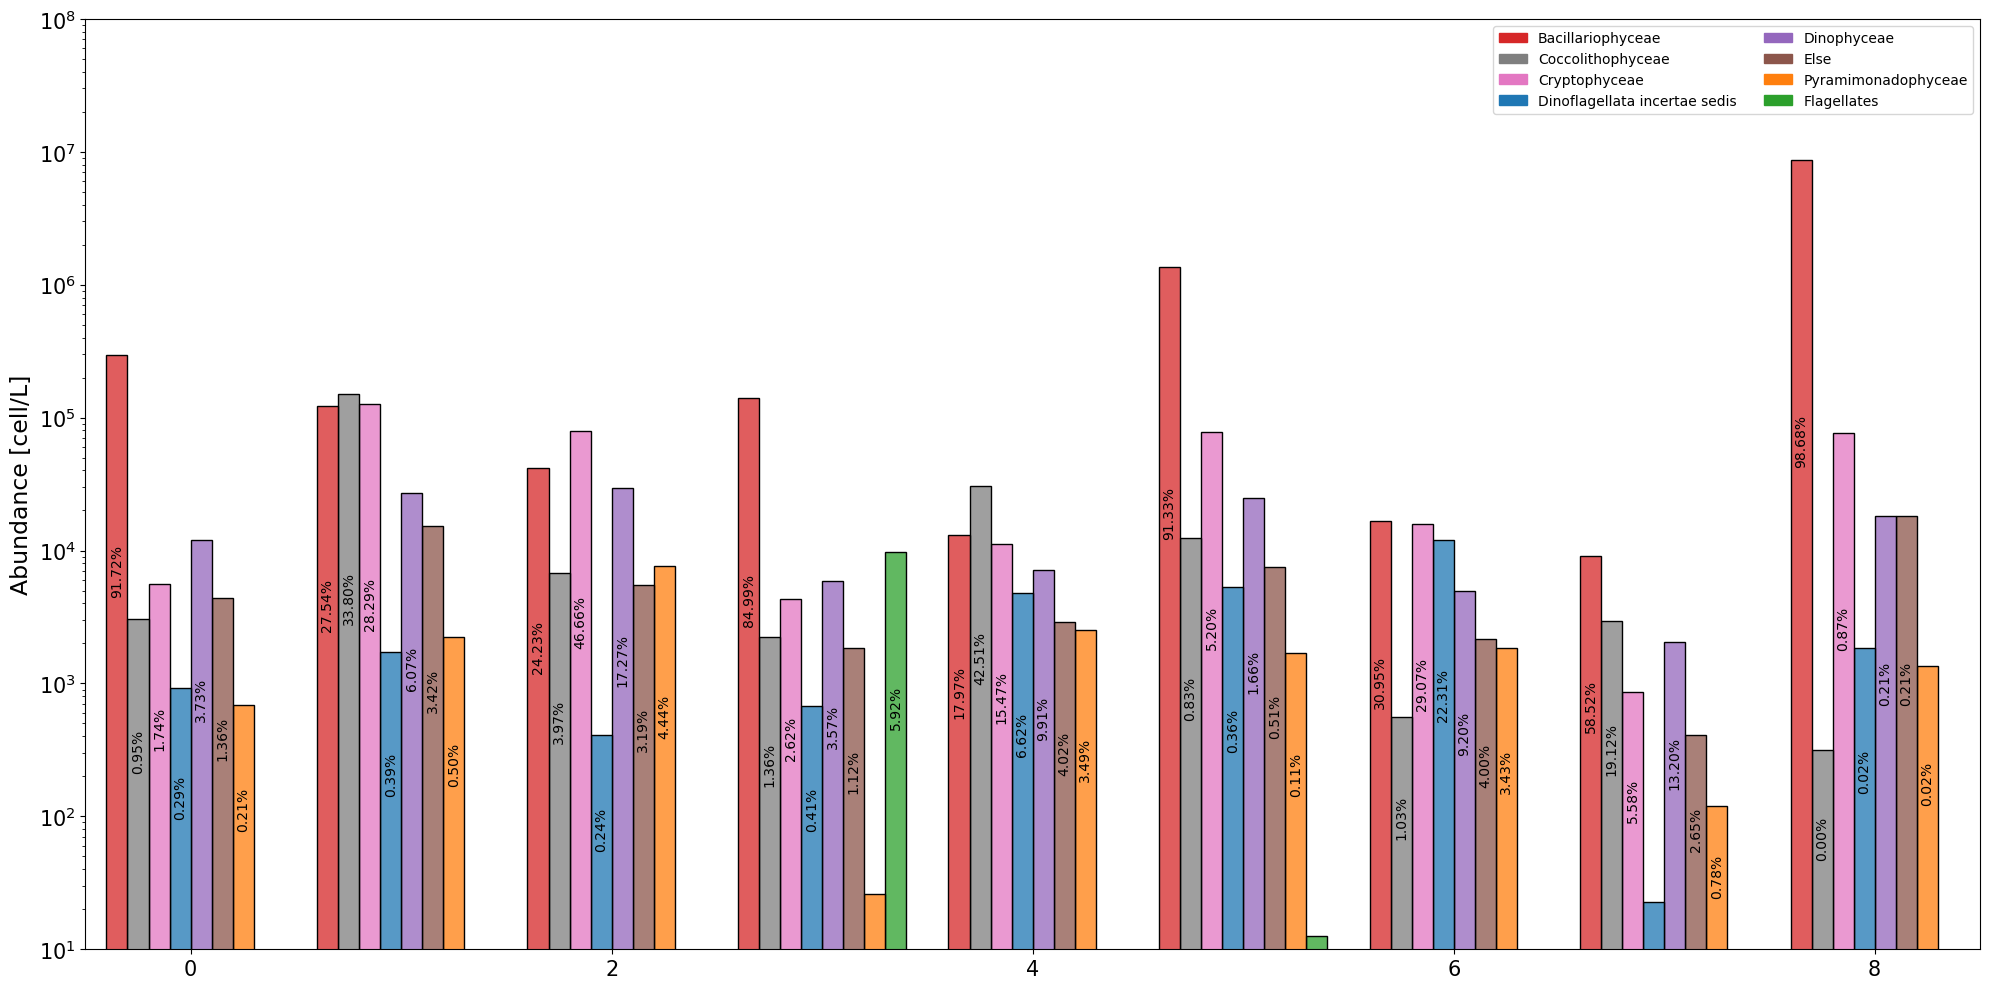

In [9]:
df = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")
df.loc[df["Class"] == "nan", "Class"] = df.loc[df["Class"] == "nan", "Taxon"]

all_names = set()
df.loc[df["Class"] == "nan", "Class"] = df.loc[df["Class"] == "nan", "Taxon"]

threshold = 0.95
class_abund = pd.DataFrame({
"Class" : [],
"Num_cell_l" : [],
"Cumsum_percent" : [],
"Cluster"  : []
})
relevant_classes = set()
#get relevant classes
for (n_clust, df_clust) in df.groupby("ward"): 
    df_clust = df_clust[["Class", "Num_cell_l"]].groupby("Class").sum(numeric_only = True).sort_values("Num_cell_l", ascending = False).reset_index()
    df_clust["Cumsum_percent"] = df_clust["Num_cell_l"].cumsum() / df_clust["Num_cell_l"].sum()
    idx = np.sum(df_clust["Cumsum_percent"].to_numpy() < threshold) + 1
    relevant_classes = relevant_classes.union(set(df_clust.iloc[:idx,0]))
    df_clust["Cluster"] = n_clust
    class_abund = pd.concat([class_abund, df_clust])
class_abund.loc[~class_abund["Class"].isin(relevant_classes), "Class"] = "Else"
class_abund = class_abund.groupby(["Cluster", "Class"]).sum(numeric_only = True).reset_index()
samples = df[["ward", "id", "Date"]].drop_duplicates().groupby("ward", observed  = True).count().rename(columns={"id" : "Num_cell_l"}, index = {"ward" : "Cluster"})
class_abund.set_index(["Cluster", "Class"], inplace = True)
class_abund.index = class_abund.index.set_levels(class_abund.index.levels[0].astype(int), level = 0)
samples.index.name = "Cluster"
class_abund["Num_cell_l"] = class_abund["Num_cell_l"].div(samples["Num_cell_l"])
class_abund = class_abund.reset_index()
class_abund = class_abund.merge(class_abund.pivot_table(
        index="Cluster", columns="Class", values="Num_cell_l"
    ).fillna(0).apply(lambda x: x / np.sum(x) * 100, axis=1).stack().reset_index().rename(columns={0: "Percentage"}), on = ["Cluster", "Class"])
all_names = all_names.union(class_abund["Class"].unique())
df = class_abund


#creating colormap
if len(all_names) <= 10:
    cmap = plt.get_cmap("tab10")
else:   
    cmap = plt.get_cmap("tab20")
colors = cmap.colors[:len(all_names)]
color_dict = {name : color for name, color in zip(all_names, colors)}

## create figure
fig, ax = plt.subplots(1,1, figsize=(20, 10)) 

## histplot 
sns.histplot(class_abund.loc[:, ["Cluster", "Class", "Num_cell_l"]], x="Cluster", hue="Class", weights="Num_cell_l", multiple="dodge", palette = color_dict, ax = ax, discrete = True, shrink = 0.8, legend=False)
ax.set_yscale("log")
ax.set_ylabel("Abundance [cell/L]", size = 17)
handles = [mpatches.Patch(color=color_dict[name], label=name) for name in class_abund["Class"].unique()]
ax.legend(handles=handles, loc='best', ncol=2)

filled_patches = list(filter(lambda x : x.get_height() > 0, ax.patches))
val_percent = class_abund[["Num_cell_l", "Percentage"]].set_index("Num_cell_l")
for p in filled_patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    values = val_percent.loc[height, "Percentage"]
    ax.annotate(text=f"{values:.2f}%", xy=(x + width / 2, 10 ** (2 * np.log10(height) / 3)), ha='center', va='bottom', rotation = 90)

ax.set_xlabel("")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
ax.set_xlim(-.5, 8.5)
ax.set_ylim(10, 10**8)
plt.tight_layout()
#plt.title("Liguria (without spring Cryptophyceae bloom)", size = 20, loc="center")

(-0.5, 8.5)

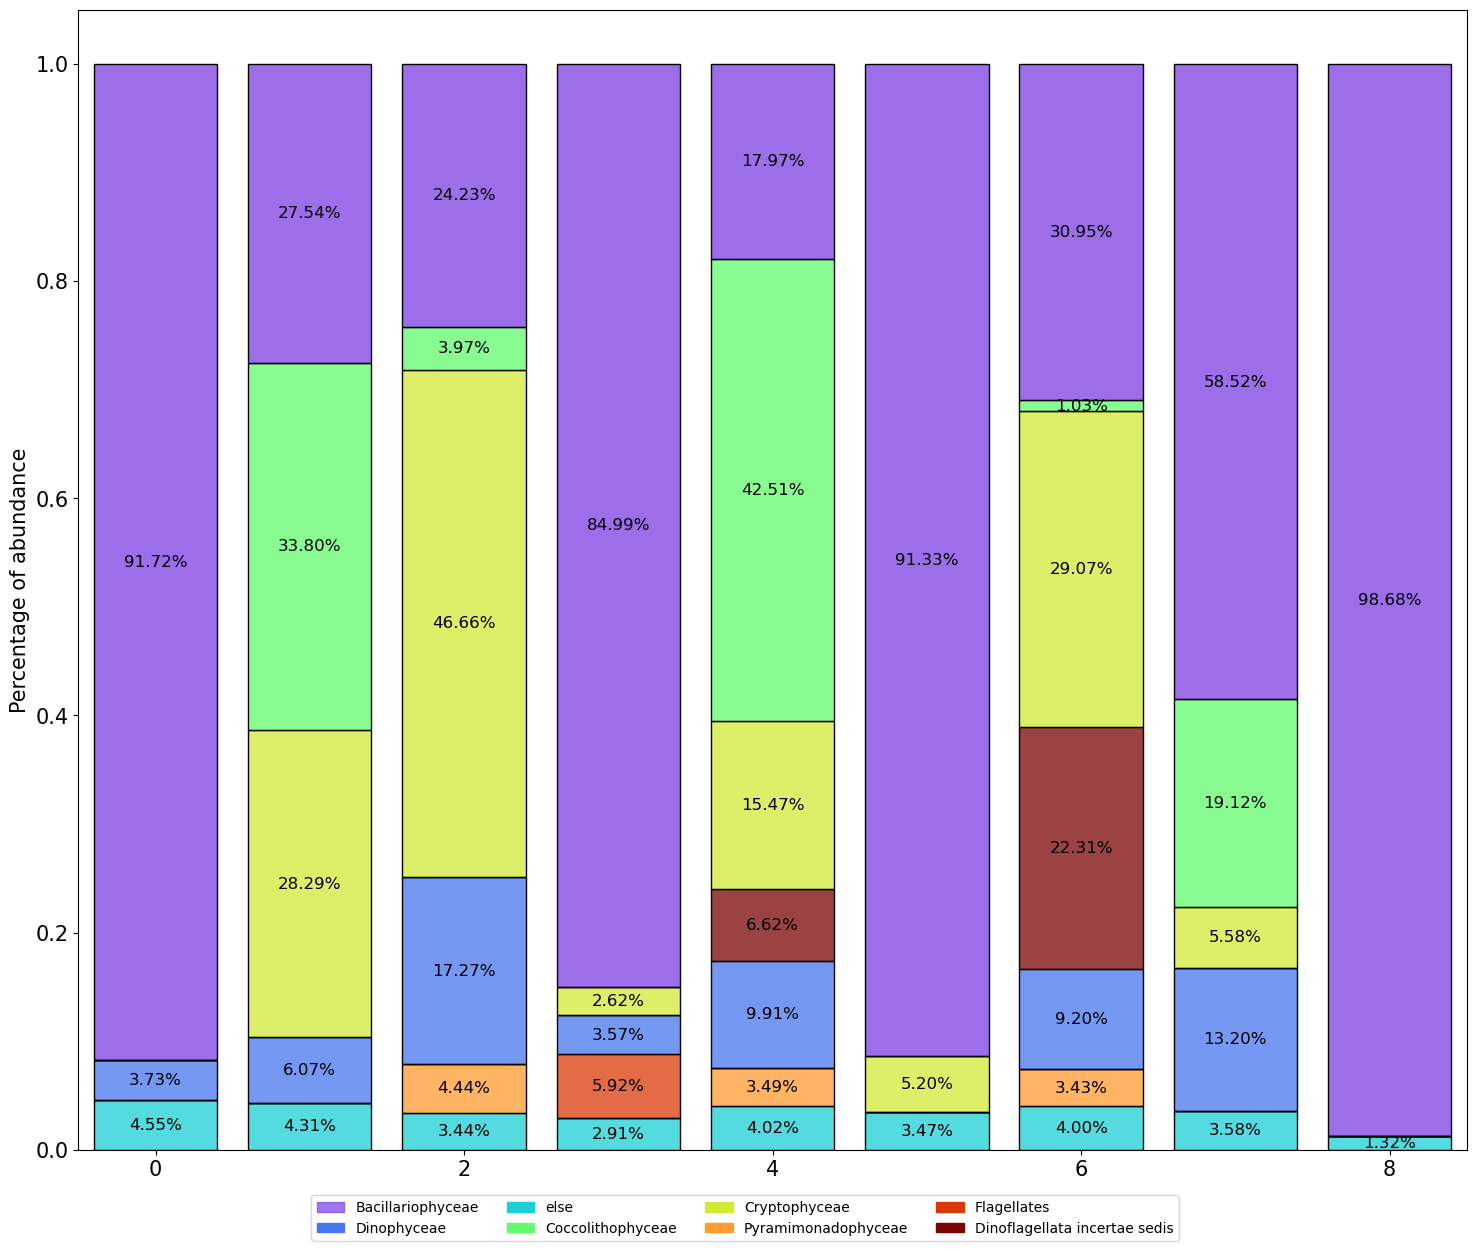

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12)) 

threshold = 0.95
df_abund_by_class = pd.DataFrame({
    "Cluster" : [], 
    "Class" : [], 
    "Num_cell_l" : []
})
method = "ward"
for (n_clust, df_clust) in phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(method): 
    df = df_clust.loc[:, ["Class", "Taxon", "Num_cell_l"]]
    df.loc[df["Class"] == "nan", "Class"] = df.loc[df["Class"] == "nan", "Taxon"]
    df = df[["Class", "Num_cell_l"]].groupby("Class").sum().sort_values("Num_cell_l", ascending = False).reset_index()
    df["Cumsum_percent"] = df["Num_cell_l"].cumsum() / df["Num_cell_l"].sum()
    idx = np.sum(df["Cumsum_percent"].to_numpy() < threshold) + 1
    df.iloc[idx:,0] = "else"
    df = df.groupby("Class").sum(numeric_only = True).reset_index()
    df["Cluster"] = n_clust
    df_abund_by_class = pd.concat([df_abund_by_class, df])

all_names = df_abund_by_class["Class"].unique()
num_colors = all_names.size
colors = plt.get_cmap("turbo")(np.linspace(0, 1, num_colors))
color_dict = {name: color for name, color in zip(all_names, colors)}
color_dict["Bacillariophyceae"] = [123 / 255, 62 / 255, 228 / 255, 0.7]


sns.histplot(
    df_abund_by_class.pivot_table(
        index="Cluster", columns="Class", values="Num_cell_l"
    ).fillna(0).apply(lambda x: x / np.sum(x), axis=1).stack().reset_index().rename(columns={0: "Percentage"}),
    x='Cluster',
    hue='Class',
    weights='Percentage',
    multiple='stack',
    discrete = True,
    ax=ax,
    palette=color_dict,
    legend=False,
    shrink = 0.8  # Adjust the binwidth to widen the distance between bars
    )
    
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height == 0:
        continue
    x, y = p.get_xy()
    ax.annotate(f'{height:.2%}', (x + width/2, y + height/2), ha='center', va='center', fontsize=12, color='black')

ax.set_xlabel("")
ax.set_ylabel("Percentage of abundance", size = 15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
ax.set_ylim(0,1.05)
handles = [mpatches.Patch(color=color_dict[name], label=name) for name in all_names]
fig.legend(handles=handles, bbox_to_anchor=(0, -.07, 1, 0.101), loc='center', ncol=4)
plt.tight_layout()
ax.set_xlim(-0.5, 8.5)
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_levels/Class_contribution_bar.png", bbox_inches='tight')

## Spectral

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
method = "spectral_1.5_10"
sns.boxplot(
   phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby([method, "id", "Date"]).agg(
    {"Num_cell_l" : "sum"}
),
    x = method, 
    y = "Num_cell_l",
    hue = method,
    ax = ax, 
    palette="tab10"
)
ax.set_yscale("log")
ax.set_title("Abundance")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
method = "spectral_1.5_10"
sns.boxplot(
   phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby([method, "id", "Date"]).agg(
    {"Taxon" : "count"}
),
    x = method, 
    y = "Taxon",
    hue = method,
    ax = ax, 
    palette="tab10"
)
ax.set_title("Richness")


(-0.05, 1.05)

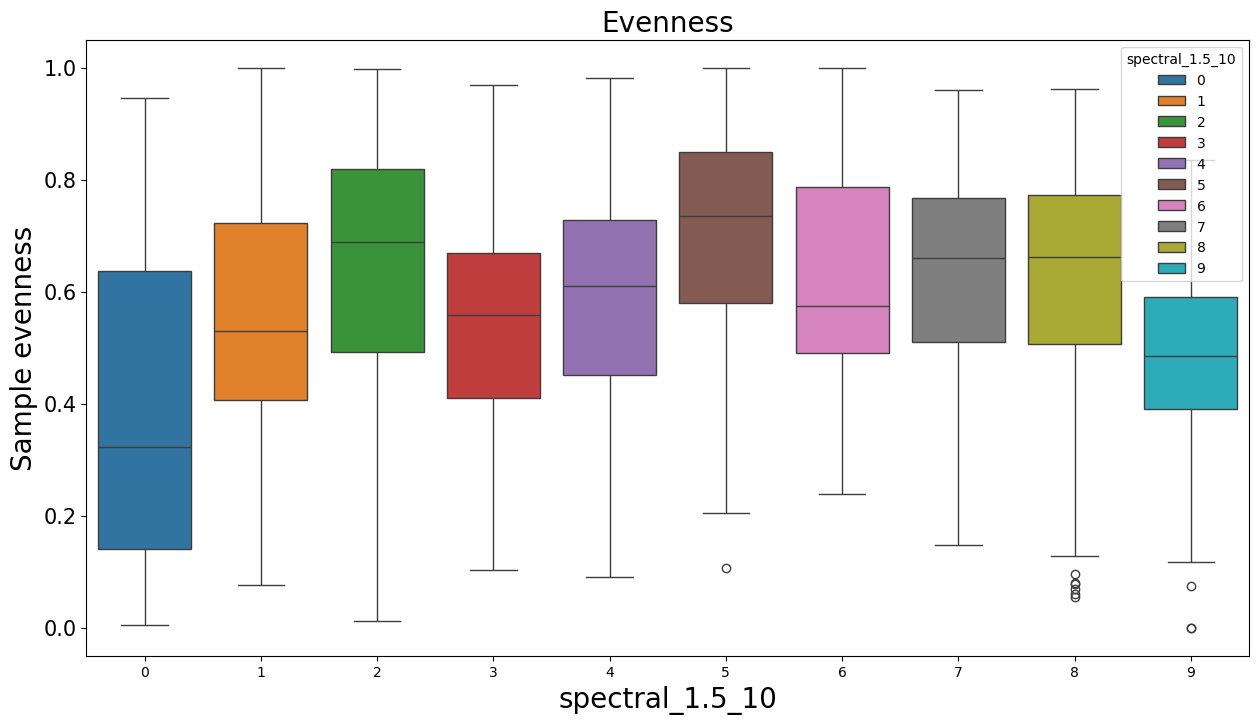

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
method = "spectral_1.5_10"
sns.boxplot(
    phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")[[method, "id", "Date", "Num_cell_l"]].groupby([method, "id", "Date"]).agg(Pielou_evenness),
    x = method, 
    y = "Num_cell_l",
    hue = method,
    palette = "tab10",
    ax = ax
)
plt.title("Evenness", size = 20)
ax.set_xlabel(xlabel = method, fontsize = 20)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 15);
ax.set_ylabel("Sample evenness", fontsize = 20)
ax.set_ylim(-0.05, 1.05)
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Even_levels/boxplot_evenness_by_region.png",bbox_inches='tight')

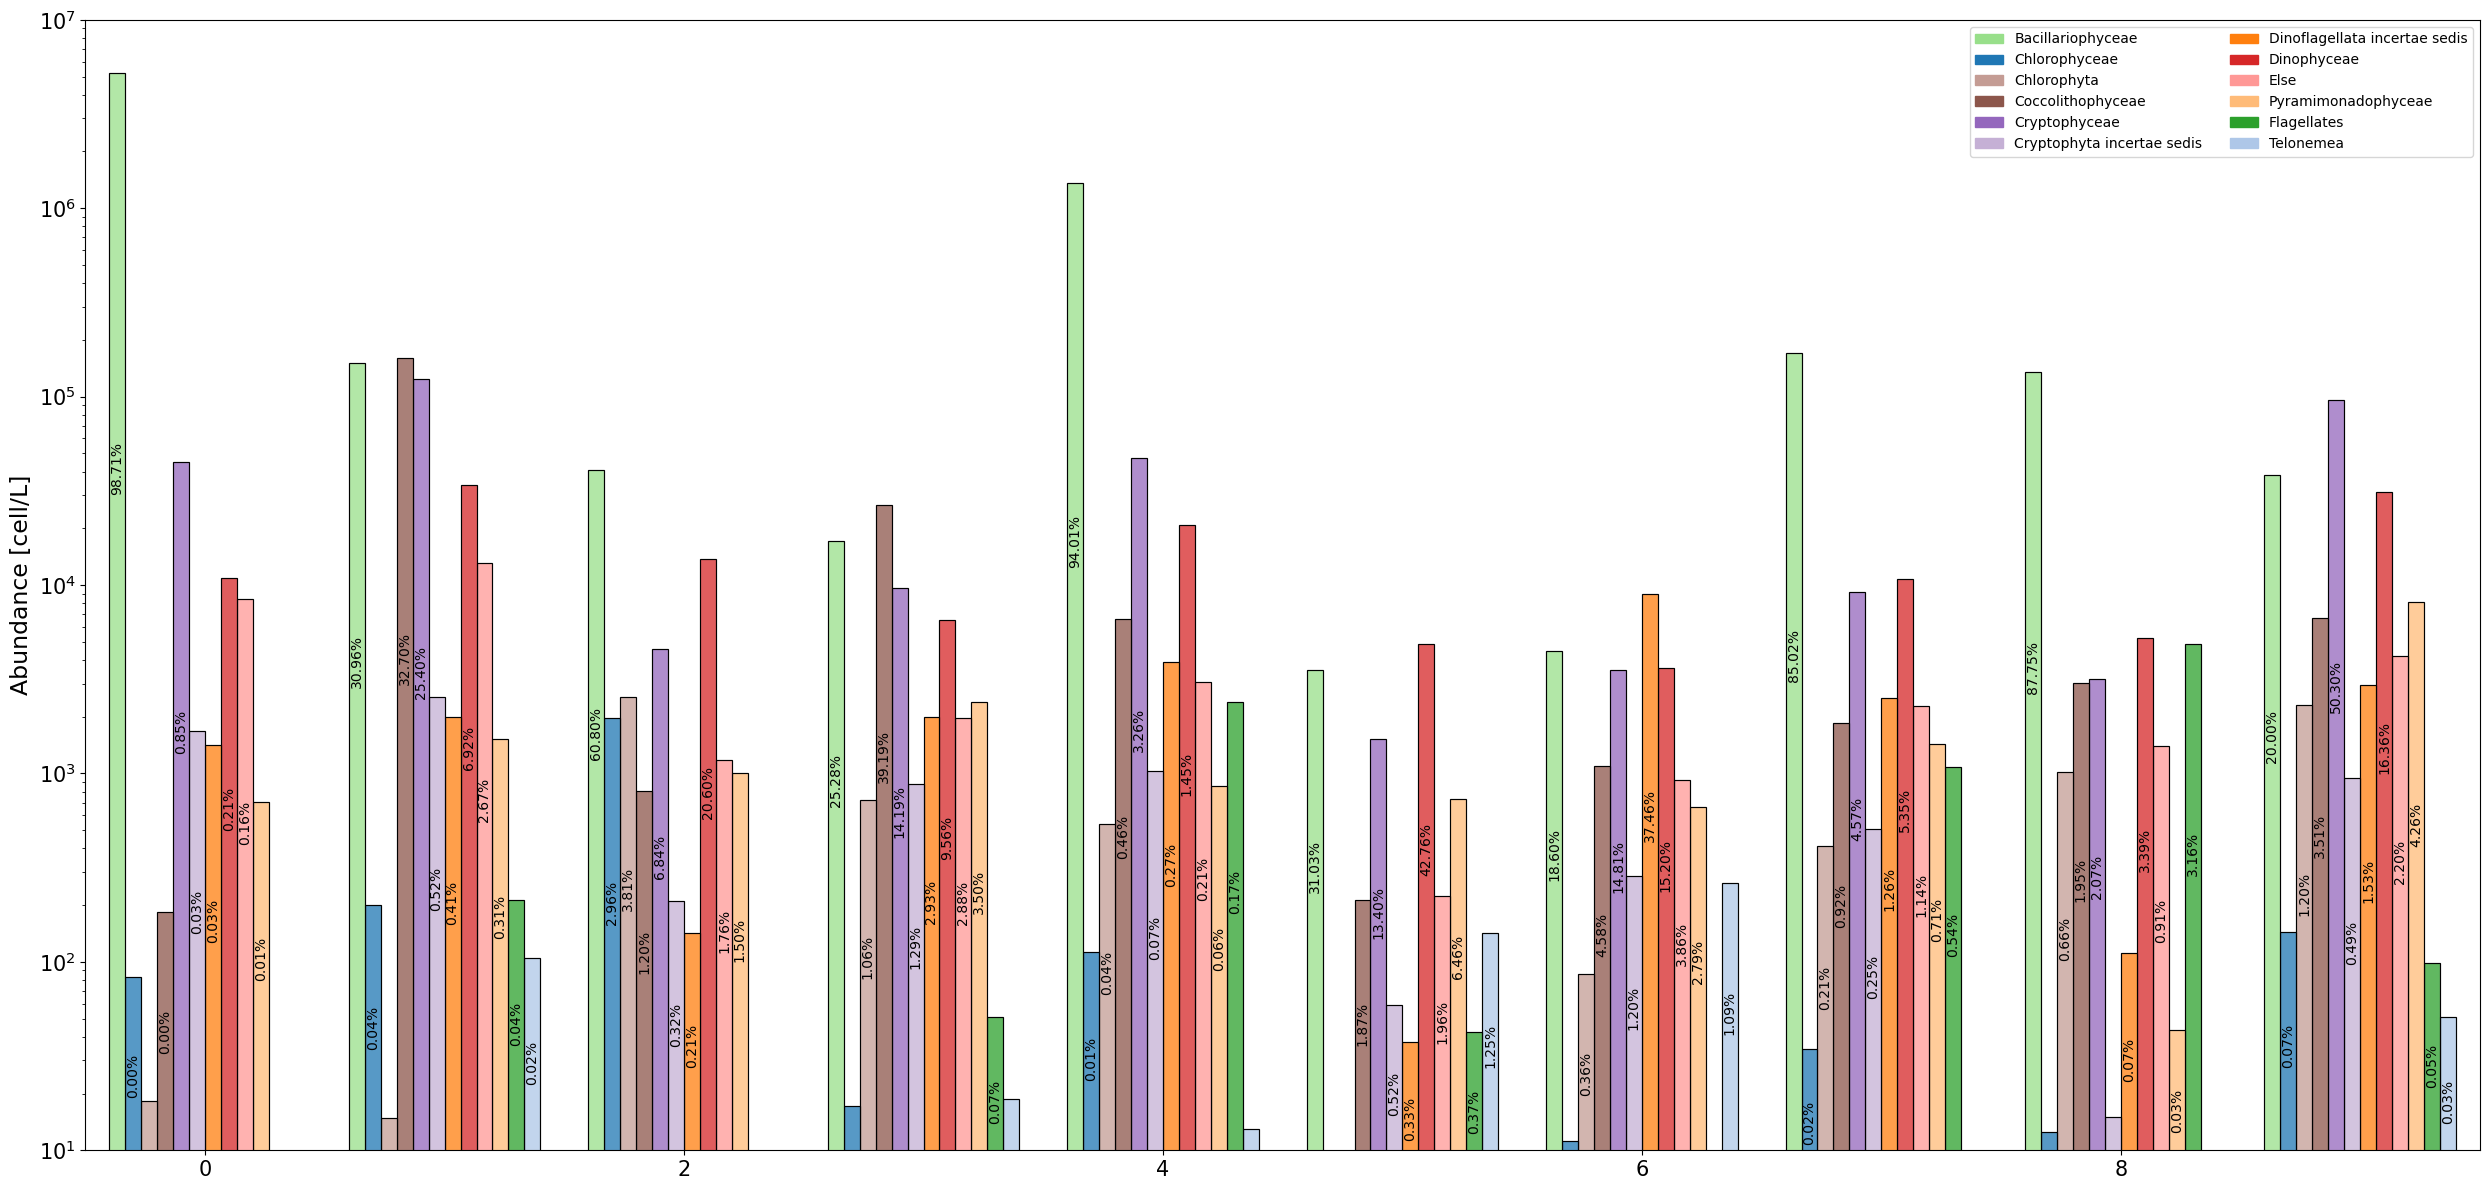

In [12]:
df = phyto_abund_simplified.query("Taxon != 'Other phytoplankton'")
df.loc[df["Class"] == "nan", "Class"] = df.loc[df["Class"] == "nan", "Taxon"]

all_names = set()
df.loc[df["Class"] == "nan", "Class"] = df.loc[df["Class"] == "nan", "Taxon"]

threshold = 0.95
class_abund = pd.DataFrame({
"Class" : [],
"Num_cell_l" : [],
"Cumsum_percent" : [],
"Cluster"  : []
})
method = "spectral_1.5_10"
relevant_classes = set()
#get relevant classes
for (n_clust, df_clust) in df.groupby(method): 
    df_clust = df_clust[["Class", "Num_cell_l"]].groupby("Class").sum(numeric_only = True).sort_values("Num_cell_l", ascending = False).reset_index()
    df_clust["Cumsum_percent"] = df_clust["Num_cell_l"].cumsum() / df_clust["Num_cell_l"].sum()
    idx = np.sum(df_clust["Cumsum_percent"].to_numpy() < threshold) + 1
    relevant_classes = relevant_classes.union(set(df_clust.iloc[:idx,0]))
    df_clust["Cluster"] = n_clust
    class_abund = pd.concat([class_abund, df_clust])
class_abund.loc[~class_abund["Class"].isin(relevant_classes), "Class"] = "Else"
class_abund = class_abund.groupby(["Cluster", "Class"]).sum(numeric_only = True).reset_index()
samples = df[[method, "id", "Date"]].drop_duplicates().groupby(method, observed  = True).count().rename(columns={"id" : "Num_cell_l"}, index = {method : "Cluster"})
class_abund.set_index(["Cluster", "Class"], inplace = True)
class_abund.index = class_abund.index.set_levels(class_abund.index.levels[0].astype(int), level = 0)
samples.index.name = "Cluster"
class_abund["Num_cell_l"] = class_abund["Num_cell_l"].div(samples["Num_cell_l"])
class_abund = class_abund.reset_index()
class_abund = class_abund.merge(class_abund.pivot_table(
        index="Cluster", columns="Class", values="Num_cell_l"
    ).fillna(0).apply(lambda x: x / np.sum(x) * 100, axis=1).stack().reset_index().rename(columns={0: "Percentage"}), on = ["Cluster", "Class"])
all_names = all_names.union(class_abund["Class"].unique())
df = class_abund


#creating colormap
if len(all_names) <= 10:
    cmap = plt.get_cmap("tab10")
else:   
    cmap = plt.get_cmap("tab20")
colors = cmap.colors[:len(all_names)]
color_dict = {name : color for name, color in zip(all_names, colors)}

## create figure
fig, ax = plt.subplots(1,1, figsize=(25, 12)) 

## histplot 
sns.histplot(class_abund.loc[:, ["Cluster", "Class", "Num_cell_l"]], x="Cluster", hue="Class", weights="Num_cell_l", multiple="dodge", palette = color_dict, ax = ax, discrete = True, shrink = 0.8, legend=False)
ax.set_yscale("log")
ax.set_ylabel("Abundance [cell/L]", size = 17)
handles = [mpatches.Patch(color=color_dict[name], label=name) for name in class_abund["Class"].unique()]
ax.legend(handles=handles, loc='best', ncol=2)

filled_patches = list(filter(lambda x : x.get_height() > 0, ax.patches))
val_percent = class_abund[["Num_cell_l", "Percentage"]].set_index("Num_cell_l")
for p in filled_patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    values = val_percent.loc[height, "Percentage"]
    ax.annotate(text=f"{values:.2f}%", xy=(x + width / 2, 10 ** (2 * np.log10(height) / 3)), ha='center', va='bottom', rotation = 90)

ax.set_xlabel("")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
ax.set_xlim(-.5, 9.5)
ax.set_ylim(10, 10**7)
plt.tight_layout()
#plt.title("Liguria (without spring Cryptophyceae bloom)", size = 20, loc="center")

(-0.5, 9.5)

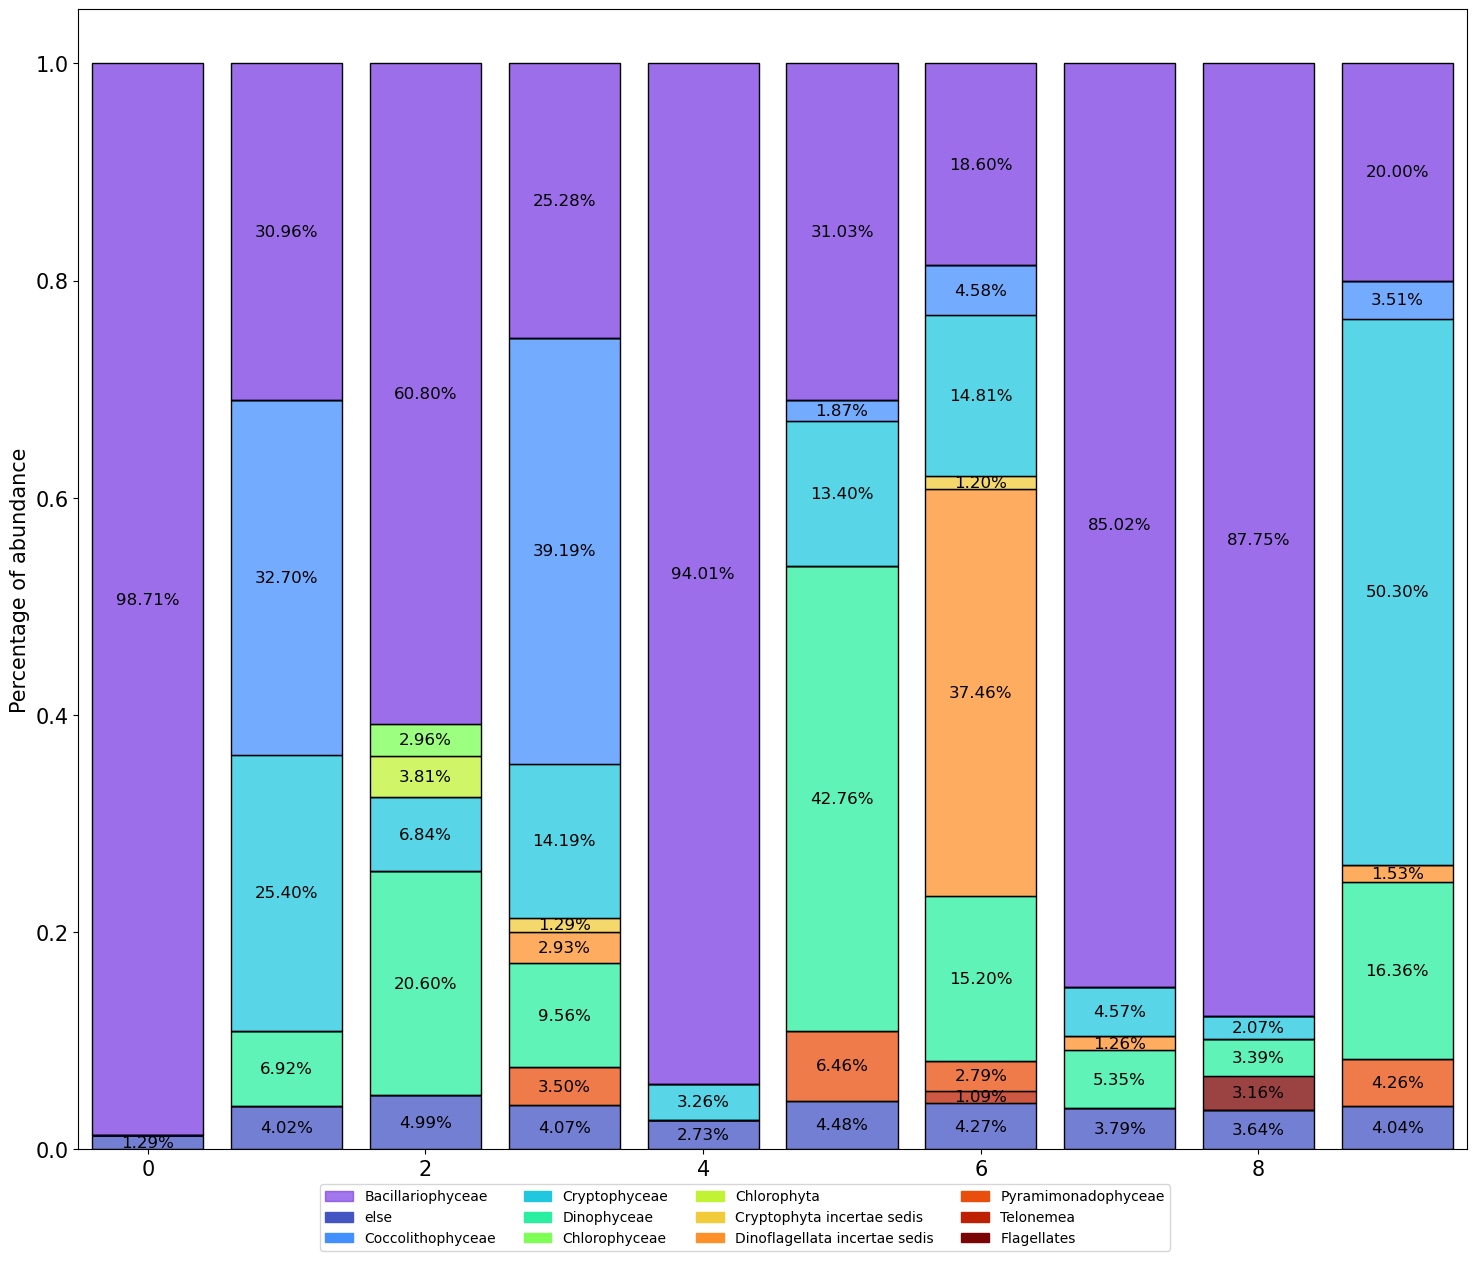

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12)) 

threshold = 0.95
df_abund_by_class = pd.DataFrame({
    "Cluster" : [], 
    "Class" : [], 
    "Num_cell_l" : []
})
method = "spectral_1.5_10"
for (n_clust, df_clust) in phyto_abund_simplified.query("Taxon != 'Other phytoplankton'").groupby(method): 
    df = df_clust.loc[:, ["Class", "Taxon", "Num_cell_l"]]
    df.loc[df["Class"] == "nan", "Class"] = df.loc[df["Class"] == "nan", "Taxon"]
    df = df[["Class", "Num_cell_l"]].groupby("Class").sum().sort_values("Num_cell_l", ascending = False).reset_index()
    df["Cumsum_percent"] = df["Num_cell_l"].cumsum() / df["Num_cell_l"].sum()
    idx = np.sum(df["Cumsum_percent"].to_numpy() < threshold) + 1
    df.iloc[idx:,0] = "else"
    df = df.groupby("Class").sum(numeric_only = True).reset_index()
    df["Cluster"] = n_clust
    df_abund_by_class = pd.concat([df_abund_by_class, df])

all_names = df_abund_by_class["Class"].unique()
num_colors = all_names.size
colors = plt.get_cmap("turbo")(np.linspace(0, 1, num_colors))
color_dict = {name: color for name, color in zip(all_names, colors)}
color_dict["Bacillariophyceae"] = [123 / 255, 62 / 255, 228 / 255, 0.7]


sns.histplot(
    df_abund_by_class.pivot_table(
        index="Cluster", columns="Class", values="Num_cell_l"
    ).fillna(0).apply(lambda x: x / np.sum(x), axis=1).stack().reset_index().rename(columns={0: "Percentage"}),
    x='Cluster',
    hue='Class',
    weights='Percentage',
    multiple='stack',
    discrete = True,
    ax=ax,
    palette=color_dict,
    legend=False,
    shrink = 0.8  # Adjust the binwidth to widen the distance between bars
    )
    
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height == 0:
        continue
    x, y = p.get_xy()
    ax.annotate(f'{height:.2%}', (x + width/2, y + height/2), ha='center', va='center', fontsize=12, color='black')

ax.set_xlabel("")
ax.set_ylabel("Percentage of abundance", size = 15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
ax.set_ylim(0,1.05)
handles = [mpatches.Patch(color=color_dict[name], label=name) for name in all_names]
fig.legend(handles=handles, bbox_to_anchor=(0, -.07, 1, 0.101), loc='center', ncol=4)
plt.tight_layout()
ax.set_xlim(-0.5, 9.5)
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_levels/Class_contribution_bar.png", bbox_inches='tight')